# **IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingClassifier

In [ ]:
pip install mlxtend

In [ ]:
pip install xgboost catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# **IMPORT & INSPECT DATASETS**

In [ ]:
telemetry_data = pd.read_csv('/content/telemetry_for_operations_training.csv')
operational_labels = pd.read_csv('/content/operations_labels_training.csv')

In [ ]:
# Display Dataset info
print(telemetry_data.info())
print("--------------------------------------------------")
print(operational_labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516073 entries, 0 to 516072
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   create_dt          516073 non-null  object 
 1   mdm_object_name    516073 non-null  int64  
 2   mdm_model_id       516073 non-null  int64  
 3   lon                516073 non-null  float64
 4   lat                516073 non-null  float64
 5   alt                516073 non-null  int64  
 6   speed_gps          516073 non-null  float64
 7   direction          516073 non-null  float64
 8   accel_forward_nn   516073 non-null  float64
 9   accel_braking_nn   516073 non-null  float64
 10  accel_angular_nn   516073 non-null  float64
 11  accel_vertical_nn  516073 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 47.2+ MB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3981 entries, 0 to 3980
Data colum

In [ ]:
# Display the first few rows of each dataset
print(telemetry_data.head())

             create_dt  mdm_object_name  mdm_model_id       lon       lat  \
0  2023-09-29 08:12:46             1498            62 -0.039352  0.005476   
1  2023-09-29 08:12:47             1498            62 -0.039367  0.005442   
2  2023-09-29 08:12:49             1498            62 -0.039382  0.005362   
3  2023-09-29 08:12:51             1498            62 -0.039397  0.005297   
4  2023-09-29 08:12:53             1498            62 -0.039413  0.005232   

   alt  speed_gps  direction  accel_forward_nn  accel_braking_nn  \
0  217       15.7      194.0             0.098             0.000   
1  216       14.4      196.0             0.000             0.294   
2  216       15.2      180.0             0.000             0.490   
3  216       12.9      198.0             0.000             0.196   
4  216       10.6      180.0             0.000             1.372   

   accel_angular_nn  accel_vertical_nn  
0             0.490               0.98  
1             0.000               1.96  
2    

In [ ]:
print(operational_labels.head())

            start_time             end_time  operation_kind_id  \
0  2023-09-26 08:00:12  2023-09-26 08:03:12                  0   
1  2023-09-26 08:03:12  2023-09-26 08:08:11                  1   
2  2023-09-26 08:08:11  2023-09-26 08:26:28                  2   
3  2023-09-26 08:26:28  2023-09-26 08:26:58                  3   
4  2023-09-26 08:27:30  2023-09-26 08:38:42                  5   

   mdm_object_name            name  
0              119            idle  
1              119         loading  
2              119   riding_loaded  
3              119  unloading_lift  
4              119    riding_empty  


In [ ]:
# 3. Get basic statistics
print(telemetry_data.describe())
print("------------------------------------------------------------------------------")
print(operational_labels.describe())

       mdm_object_name   mdm_model_id           lon           lat  \
count    516073.000000  516073.000000  5.160730e+05  5.160730e+05   
mean        702.413372      61.461065 -5.794578e+02 -5.794038e+02   
std         636.085455       0.498482  2.406669e+04  2.406445e+04   
min         119.000000      61.000000 -1.000142e+06 -1.000049e+06   
25%         121.000000      61.000000 -2.191073e-02 -9.752221e-03   
50%         125.000000      61.000000  7.569250e-03  2.370887e-03   
75%        1436.000000      62.000000  2.118009e-02  9.000830e-03   
max        1498.000000      62.000000  3.247159e-02  2.044874e-02   

                 alt      speed_gps      direction  accel_forward_nn  \
count  516073.000000  516073.000000  516073.000000     516073.000000   
mean       42.494349      13.473738     176.415423          0.246462   
std        94.651927      10.384209     102.775215          0.547236   
min      -146.000000       0.000000       0.000000          0.000000   
25%       -42.0000

In [ ]:
# 5. Check unique values for categorical columns
print(telemetry_data['mdm_model_id'].value_counts())

mdm_model_id
61    278130
62    237943
Name: count, dtype: int64


In [ ]:
# Check unique values for operation_kind_id
print(operational_labels['operation_kind_id'].value_counts())

operation_kind_id
5    1042
2     783
3     726
1     723
0     707
Name: count, dtype: int64


In [ ]:
# 6. Check for duplicates
print(telemetry_data.duplicated().sum())
print("--------------------------------------------")
print(operational_labels.duplicated().sum())

14891
--------------------------------------------
0


# **DATA PREPROCESSING**

In [ ]:
# Remove duplicates
telemetry_data = telemetry_data.drop_duplicates()

In [ ]:
# Convert the relevant columns to datetime
telemetry_data['create_dt'] = pd.to_datetime(telemetry_data['create_dt'], errors='coerce')
operational_labels['start_time'] = pd.to_datetime(operational_labels['start_time'], errors='coerce')
operational_labels['end_time'] = pd.to_datetime(operational_labels['end_time'], errors='coerce')

In [ ]:
# Display Dataset info
print(telemetry_data.info())
print("--------------------------------------------------")
print(operational_labels.info())

<class 'pandas.core.frame.DataFrame'>
Index: 501182 entries, 0 to 516072
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   create_dt          501172 non-null  datetime64[ns]
 1   mdm_object_name    501182 non-null  int64         
 2   mdm_model_id       501182 non-null  int64         
 3   lon                501182 non-null  float64       
 4   lat                501182 non-null  float64       
 5   alt                501182 non-null  int64         
 6   speed_gps          501182 non-null  float64       
 7   direction          501182 non-null  float64       
 8   accel_forward_nn   501182 non-null  float64       
 9   accel_braking_nn   501182 non-null  float64       
 10  accel_angular_nn   501182 non-null  float64       
 11  accel_vertical_nn  501182 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 49.7 MB
None
-----------------------------------

In [ ]:
# Drop rows with NaT values in 'create_dt'
telemetry_data = telemetry_data.dropna(subset=['create_dt'])

In [ ]:
merged_data = pd.read_csv('/content/final_merged_data.csv')

In [ ]:
merged_data['create_dt'] = pd.to_datetime(merged_data['create_dt'], errors='coerce')

In [ ]:
# Now perform the merge based on the timestamp
'''merged_data = pd.merge_asof(telemetry_data.sort_values('create_dt'),
                           operational_labels.sort_values('start_time'),
                            by='mdm_object_name',
                            left_on='create_dt',
                            right_on='start_time',
                            direction='nearest',
                            tolerance=pd.Timedelta('180m'))'''

In [ ]:
# Extract features from 'create_dt', 'start_time', and 'end_time'
merged_data['create_hour'] = merged_data['create_dt'].dt.hour
merged_data['create_day'] = merged_data['create_dt'].dt.dayofweek

In [ ]:
merged_data.columns

Index(['create_dt', 'mdm_object_name', 'mdm_model_id', 'lon', 'lat', 'alt',
       'speed_gps', 'direction', 'accel_forward_nn', 'accel_braking_nn',
       'accel_angular_nn', 'accel_vertical_nn', 'start_time', 'end_time',
       'operation_kind_id', 'name'],
      dtype='object')

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496733 entries, 0 to 496732
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   create_dt          496733 non-null  datetime64[ns]
 1   mdm_object_name    496733 non-null  int64         
 2   mdm_model_id       496733 non-null  int64         
 3   lon                496733 non-null  float64       
 4   lat                496733 non-null  float64       
 5   alt                496733 non-null  int64         
 6   speed_gps          496733 non-null  float64       
 7   direction          496733 non-null  float64       
 8   accel_forward_nn   496733 non-null  float64       
 9   accel_braking_nn   496733 non-null  float64       
 10  accel_angular_nn   496733 non-null  float64       
 11  accel_vertical_nn  496733 non-null  float64       
 12  start_time         496733 non-null  object        
 13  end_time           496733 non-null  object  

In [ ]:
# Filter out rows where the telemetry time is outside the start_time and end_time intervals
#merged_data = merged_data[(merged_data['create_dt'] >= merged_data['start_time']) & (merged_data['create_dt'] <= merged_data['end_time'])]

In [ ]:
merged_data.shape

(496733, 16)

In [ ]:
# Filter numeric columns only for correlation calculation
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64', 'int32'])

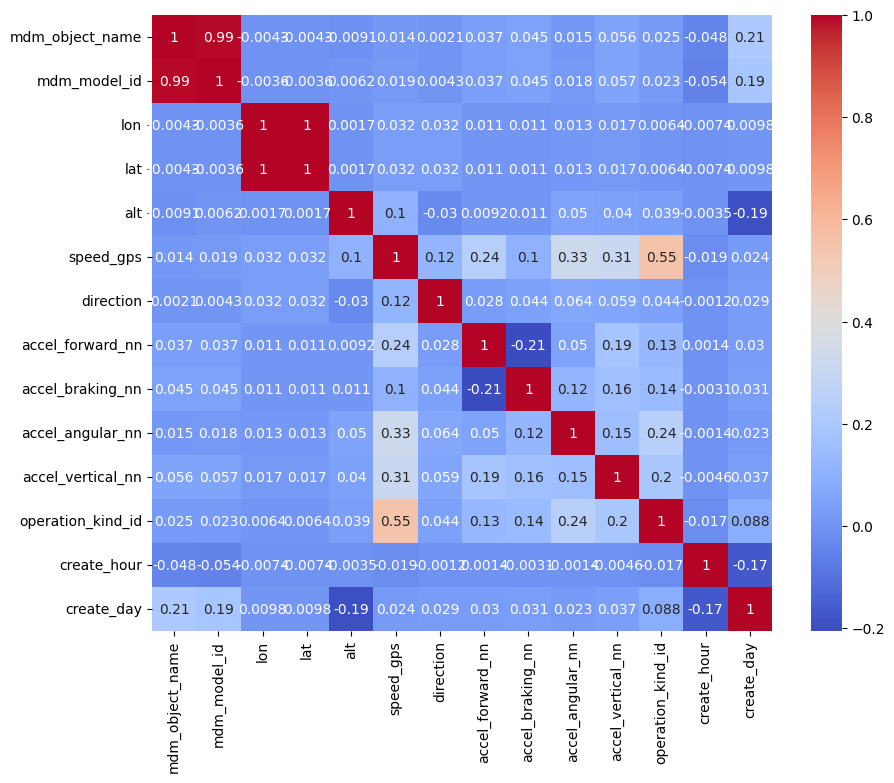

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Define the columns to scale (exclude the target variable if any)
numeric_features = ['speed_gps', 'accel_forward_nn', 'accel_braking_nn', 'accel_angular_nn', 'accel_vertical_nn', 'lon', 'lat', 'alt ','direction']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numeric columns
merged_data[numeric_features] = scaler.fit_transform(merged_data[numeric_features])

In [ ]:
# remove nan from merged_data
merged_data = merged_data.dropna()

# **TRAIN/TEST SPLIT**

In [ ]:
# Define the target and features (assuming 'operation_kind_id' is the target)
X = merged_data.drop(columns=['operation_kind_id','create_dt','start_time','end_time','name'])
y = merged_data['operation_kind_id']

In [ ]:
# Check the shape of X and y
print(X.shape)
print(y.shape)

(496733, 9)
(496733,)


In [ ]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15 ,random_state=52)

In [ ]:
# Optional: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **MODEL TRAINING**

In [ ]:
# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test data
#y_pred = rf_model.predict(X_test)

# Evaluate the model
#print(classification_report(y_test, y_pred))

RandomForestClassifier(random_state=42)

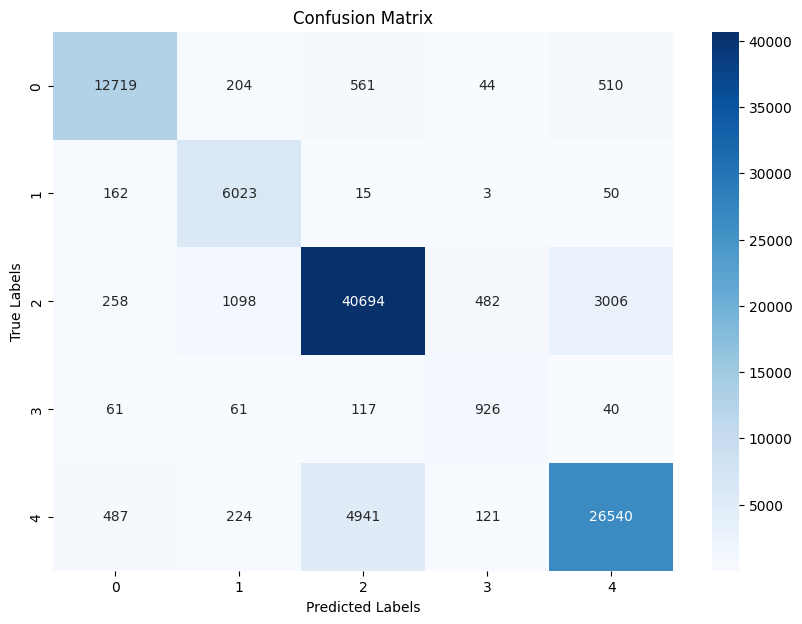

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],            # Number of trees in the forest
    'max_depth': [10, 20, 30, None],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples required at each leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'bootstrap': [True, False]                 # Whether bootstrap samples are used
}

In [ ]:
# Initialize Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

In [ ]:
# 1. Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.9, random_state=42)
gb_clf.fit(X_train, y_train)
gb_predictions = gb_clf.predict(X_test)

In [ ]:
# Map the labels: change 5 to 4
y_train_mapped = y_train.copy()
y_test_mapped = y_test.copy()

# Remapping label 5 to 4
y_train_mapped = np.where(y_train == 5, 4, y_train)
y_test_mapped = np.where(y_test == 5, 4, y_test)

# Initialize the models
xgb_model = XGBClassifier(random_state=42)   # XGBoost

# Fit the models on training data
xgb_model.fit(X_train, y_train_mapped)

# Predictions on the test data
xgb_pred = xgb_model.predict(X_test)

# Remap the predictions if needed
xgb_predictions_original = np.where(xgb_pred == 4, 5, xgb_pred)

In [ ]:
catboost_model = CatBoostClassifier(random_state=42, silent=True)  # CatBoost
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_test)

In [ ]:
# Initialize AdaBoost model
ab_model = AdaBoostClassifier(n_estimators=100, random_state=42)
# Train the AdaBoost model
ab_model.fit(X_train, y_train_mapped)  # Use the relabeled y_train_mapped if you're dealing with consecutive classes
# Make predictions
adaboost_predictions = ab_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:

# Support Vector Machine
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
svm_predictions = svm_clf.predict(X_test)


In [ ]:

# Naive Bayes
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
nb_predictions = nb_clf.predict(X_test)

In [ ]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (64, 64), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001,0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [ 500, 700, 1000]
}

# Use the threading backend to avoid parallel processing issues
from sklearn.utils import parallel_backend

#with parallel_backend('threading'):
mlp = MLPClassifier(random_state=2)
mlp.fit(X_train, y_train)
#mlp_predictions = mlp.predict(X_test)

MLPClassifier(random_state=2)

In [ ]:
# Meta-model
meta_model = mlp

In [ ]:
# Stacking classifier
stacked_model = StackingClassifier(classifiers=[rf_model, gb_clf],
                                   meta_classifier=meta_model)

In [ ]:
# Fit the stacked model
stacked_model.fit(X_train, y_train)
# Predictions on test data
stacked_pred = stacked_model.predict(X_test)

# **VALIDATION**

In [ ]:
# Load the telemetry validation data
validation_data = pd.read_csv('/content/telemetry_for_operations_validation.csv')

In [ ]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260111 entries, 0 to 260110
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   create_dt          260111 non-null  object 
 1   mdm_object_name    260111 non-null  int64  
 2   mdm_model_id       260111 non-null  int64  
 3   lon                260111 non-null  float64
 4   lat                260111 non-null  float64
 5   alt                260111 non-null  int64  
 6   speed_gps          260111 non-null  float64
 7   direction          260111 non-null  float64
 8   accel_forward_nn   260111 non-null  float64
 9   accel_braking_nn   260111 non-null  float64
 10  accel_angular_nn   260111 non-null  float64
 11  accel_vertical_nn  260111 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 23.8+ MB


In [ ]:
# 6. Check for duplicates
print(validation_data.duplicated().sum())

0


In [ ]:
validation_data.columns

Index(['create_dt', 'mdm_object_name', 'mdm_model_id', 'lon', 'lat', 'alt',
       'speed_gps', 'direction', 'accel_forward_nn', 'accel_braking_nn',
       'accel_angular_nn', 'accel_vertical_nn'],
      dtype='object')

In [ ]:
# Step 2: Convert 'create_dt' to datetime if it's not already
validation_data['create_dt_time'] = pd.to_datetime(validation_data['create_dt'], errors='coerce')

In [ ]:
validation_data['create_hour'] = validation_data['create_dt_time'].dt.hour
validation_data['create_day'] = validation_data['create_dt_time'].dt.dayofweek

In [ ]:
# Select the same features used during training
X_validation = validation_data[['mdm_object_name', 'mdm_model_id', 'lon', 'lat', 'alt', 'speed_gps','direction','accel_forward_nn',
                          'accel_braking_nn','accel_angular_nn','accel_vertical_nn']]

In [ ]:
# Predict the operation_kind_id
y_pred_validation = mlp.predict(X_validation)

In [ ]:
#unique values in y_pred_validation
unique_values = np.unique(y_pred_validation)
print(unique_values)

[0 1 2 3 5]


In [ ]:
# Remap the predictions if needed
y_pred_validation = np.where(y_pred_validation == 4, 5, y_pred_validation)

In [ ]:
# Add the predictions to the DataFrame
validation_data['operation_kind_id'] = y_pred_validation

In [ ]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260111 entries, 0 to 260110
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   create_dt          260111 non-null  object        
 1   mdm_object_name    260111 non-null  int64         
 2   mdm_model_id       260111 non-null  int64         
 3   lon                260111 non-null  float64       
 4   lat                260111 non-null  float64       
 5   alt                260111 non-null  int64         
 6   speed_gps          260111 non-null  float64       
 7   direction          260111 non-null  float64       
 8   accel_forward_nn   260111 non-null  float64       
 9   accel_braking_nn   260111 non-null  float64       
 10  accel_angular_nn   260111 non-null  float64       
 11  accel_vertical_nn  260111 non-null  float64       
 12  create_dt_time     260107 non-null  datetime64[ns]
 13  operation_kind_id  260111 non-null  int64   

In [ ]:
validation_data['operation_kind_id'].value_counts()

,count
operation_kind_id,
2,115294
5,74343
0,61661
1,6620
3,2193


In [ ]:
# Step 8: Create the output DataFrame with the desired columns
output_data = validation_data[['create_dt', 'mdm_object_name', 'operation_kind_id']]

# Step 9: Save the output to a CSV file
output_data.to_csv('operation_kind_predictions_mlp6.csv', index=False, lineterminator='\r\n')

# **TIME SERIES**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
data = merged_data

In [ ]:
data.set_index('create_dt', inplace=True)

In [ ]:
# Train ARIMA
arima_model = ARIMA(data['operation_kind_id'], order=(1, 1, 1))
arima_result = arima_model.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-

In [ ]:
# Set create_dt as the index
validation_data.set_index('create_dt_time', inplace=True)

In [ ]:
# Forecast the length of your validation set
forecast = arima_result.forecast(steps=len(validation_data))

# Convert forecasted values to a DataFrame for better handling
forecast_index = validation_data.index[:len(forecast)]
predictions = pd.DataFrame(forecast, index=forecast_index, columns=['PredictedID'])

# Join predictions with the validation data if you want to see them together
results = validation_data.join(predictions)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# **MERGE DATA (CHUNKS)**

In [ ]:
# Sort both DataFrames by mdm_object_name and time columns
telemetry_data = telemetry_data.sort_values(['mdm_object_name', 'create_dt'])
operational_labels = operational_labels.sort_values(['mdm_object_name', 'start_time'])

In [ ]:
chunk_size = 1000

In [ ]:
# Initialize a list to store the results
result_list = []

In [ ]:
l = len(telemetry_data)
print(l)

501172


In [ ]:
# Process telemetry_data in chunks
for i in range(0, l, chunk_size):
    # Extract the current chunk of telemetry_data
    chunk = telemetry_data.iloc[i:i + chunk_size]

    # Initialize a list to store combined rows for this chunk
    merged_rows = []

    # Iterate through each row in the chunk
    for index, row in chunk.iterrows():
        # Filter operations_data based on conditions
        filtered_operations = operational_labels[
            (operational_labels['mdm_object_name'] == row['mdm_object_name']) &
            (row['create_dt'] >= operational_labels['start_time']) &
            (row['create_dt'] <= operational_labels['end_time'])
        ]

        # If there are matches, combine the row with the filtered operations
        if not filtered_operations.empty:
            for _, op_row in filtered_operations.iterrows():
                combined_row = {**row, **op_row}  # Merge the dictionaries
                merged_rows.append(combined_row)  # Add to list instead of appending to DataFrame

    # Convert the list of combined rows to a DataFrame
    merged_chunk = pd.DataFrame(merged_rows)

    # Append the merged results from the current chunk to the result list
    result_list.append(merged_chunk)

    print(f"Processed chunk {i // chunk_size + 1} / {l // chunk_size + 1}")


Processed chunk 1 / 502
Processed chunk 2 / 502
Processed chunk 3 / 502
Processed chunk 4 / 502
Processed chunk 5 / 502
Processed chunk 6 / 502
Processed chunk 7 / 502
Processed chunk 8 / 502
Processed chunk 9 / 502
Processed chunk 10 / 502
Processed chunk 11 / 502
Processed chunk 12 / 502
Processed chunk 13 / 502
Processed chunk 14 / 502
Processed chunk 15 / 502
Processed chunk 16 / 502
Processed chunk 17 / 502
Processed chunk 18 / 502
Processed chunk 19 / 502
Processed chunk 20 / 502
Processed chunk 21 / 502
Processed chunk 22 / 502
Processed chunk 23 / 502
Processed chunk 24 / 502
Processed chunk 25 / 502
Processed chunk 26 / 502
Processed chunk 27 / 502
Processed chunk 28 / 502
Processed chunk 29 / 502
Processed chunk 30 / 502
Processed chunk 31 / 502
Processed chunk 32 / 502
Processed chunk 33 / 502
Processed chunk 34 / 502
Processed chunk 35 / 502
Processed chunk 36 / 502
Processed chunk 37 / 502
Processed chunk 38 / 502
Processed chunk 39 / 502
Processed chunk 40 / 502
Processed

In [ ]:
# Concatenate all chunks into a single DataFrame
final_merged_data = pd.concat(result_list, ignore_index=True)

# Now you have the fully merged data

In [ ]:
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496733 entries, 0 to 496732
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   create_dt          496733 non-null  datetime64[ns]
 1   mdm_object_name    496733 non-null  int64         
 2   mdm_model_id       496733 non-null  int64         
 3   lon                496733 non-null  float64       
 4   lat                496733 non-null  float64       
 5   alt                496733 non-null  int64         
 6   speed_gps          496733 non-null  float64       
 7   direction          496733 non-null  float64       
 8   accel_forward_nn   496733 non-null  float64       
 9   accel_braking_nn   496733 non-null  float64       
 10  accel_angular_nn   496733 non-null  float64       
 11  accel_vertical_nn  496733 non-null  float64       
 12  start_time         496733 non-null  datetime64[ns]
 13  end_time           496733 non-null  datetime

In [ ]:
# convert final_merged_data to csv file
final_merged_data.to_csv('final_merged_data.csv', index=False)

# **LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Normalize the operation_kind_id for training
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(merged_data[['operation_kind_id']])

# Create sequences for LSTM
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Set the number of time steps (e.g., 10)
time_steps = 10
X_train, y_train = create_sequences(train_scaled, time_steps)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\ekamb\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Fit the model on the training data
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 159s 10ms/step - loss: 0.0041
Epoch 2/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 149s 10ms/step - loss: 0.0037
Epoch 3/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 196s 9ms/step - loss: 0.0037
Epoch 4/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 202s 9ms/step - loss: 0.0037
Epoch 5/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 143s 9ms/step - loss: 0.0035
Epoch 6/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 202s 9ms/step - loss: 0.0035
Epoch 7/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 147s 9ms/step - loss: 0.0034
Epoch 8/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 145s 9ms/step - loss: 0.0035
Epoch 9/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 146s 9ms/step - loss: 0.0034
Epoch 10/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 198s 9ms/step - loss: 0.0036
Epoch 11/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 203s 9ms/step - loss: 0.0035
Epoch 12/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 201s 9ms/step - loss: 0.0036
Epoch 13/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 203s 9ms/step - loss: 0.0036
Epoch 14/20
15523/15523 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Normalize relevant features
scaler = MinMaxScaler(feature_range=(0, 1))
validation_scaled = scaler.fit_transform(validation_data[['mdm_object_name', 'mdm_model_id', 'lon', 'lat', 'alt',
       'speed_gps', 'direction', 'accel_forward_nn', 'accel_braking_nn',
       'accel_angular_nn', 'accel_vertical_nn']])  # Use appropriate features

# Create sequences for validation data
def create_sequences(data, time_steps=1):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
    return np.array(X)

# Set the number of time steps (e.g., 10)
time_steps = 10
X_validation = create_sequences(validation_scaled, time_steps)

# Reshape input to be [samples, time steps, features] for LSTM
X_validation = X_validation.reshape((X_validation.shape[0], X_validation.shape[1], 1))

In [ ]:
# Assuming 'model' is your trained LSTM model
predictions = model.predict(X_validation)

In [ ]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(y_train.reshape(-1, 1))  # Fit the scaler on the target during training

MinMaxScaler()

In [ ]:
# Inverse transform to get original scale
predictions_inverse = target_scaler.inverse_transform(predictions)

In [ ]:
predictions_inverse.shape

(260101, 1)

In [ ]:
predictions

array([[9.8771858e-01],
       [9.8771858e-01],
       [9.8771858e-01],
       ...,
       [7.4595213e-04],
       [7.4595213e-04],
       [7.4595213e-04]], dtype=float32)